# XRD Analysis

## Raw Data

<IPython.core.display.Javascript object>


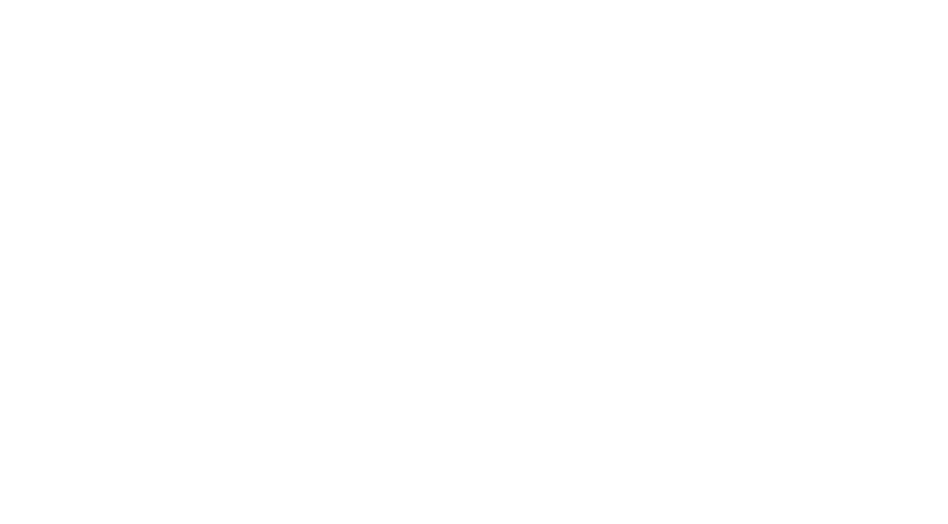

,two_theta,intensity
0,10.00,4625.0
1,10.01,4715.0
2,10.02,4460.0
3,10.03,4520.0
4,10.04,4135.0


In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import scipy
from scipy import signal
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
from lmfit import Model
from scipy.optimize import curve_fit
from IPython.display import display
import ipywidgets as widgets
import re


# Enable interactive plots in Jupyter Notebook
%matplotlib nbagg

# Set the path to the foldercontaining text files
folder_path = "C:\\Users\\w16025698\\OneDrive - Northumbria University - Production Azure AD\\PhD\\Characterisation\\XRD\\230607_XRD"

file_name = "230310E_XRD.xy"
file_title = file_name.replace('.xy', '')

# Read the data from the text file, skipping the first lines
df = pd.read_csv(os.path.join(folder_path, file_name), sep=" ", skiprows=717, header=None, names=["two_theta", "intensity"])
#df = pd.read_csv(os.path.join(folder_path, file_name), sep="\t", header=None, names=["two_theta", "intensity", "NA"])

# Load the XRD reference pattern from Excel
reference_path = 'C:\\Users\\w16025698\\OneDrive - Northumbria University - Production Azure AD\\PhD\\Characterisation\\XRD\\XRD ref patterns.xlsx'
CZTSe_reference_df = pd.read_excel(reference_path, sheet_name='CZTSe')
CZTS_reference_df = pd.read_excel(reference_path, sheet_name='CZTS')
MoSe2_reference_df = pd.read_excel(reference_path, sheet_name='MoSe2')
Mo_reference_df = pd.read_excel(reference_path, sheet_name='Mo')

CZTSe_reference_df = CZTSe_reference_df.rename(columns={CZTSe_reference_df.columns[0]: 'Two Theta', CZTSe_reference_df.columns[1]: 'Intensity'})
CZTS_reference_df = CZTS_reference_df.rename(columns={CZTS_reference_df.columns[0]: 'Two Theta', CZTS_reference_df.columns[1]: 'Intensity'})
MoSe2_reference_df = MoSe2_reference_df.rename(columns={MoSe2_reference_df.columns[0]: 'Two Theta', MoSe2_reference_df.columns[1]: 'Intensity'})
Mo_reference_df = Mo_reference_df.rename(columns={Mo_reference_df.columns[0]: 'Two Theta', Mo_reference_df.columns[1]: 'Intensity'})

# Create a simple line plot of the XRD raw data
plt.plot(df["two_theta"], df["intensity"])
plt.xlabel("2θ (degrees)")
plt.ylabel("Intensity (counts)")
plt.title(file_title)
plt.show()

# View the first few rows of the DataFrame
df.head()

## Peak Locator Function

This code block finds the approximate peak position allowing for the determination and subsequent subtraction of the baseline

<IPython.core.display.Javascript object>


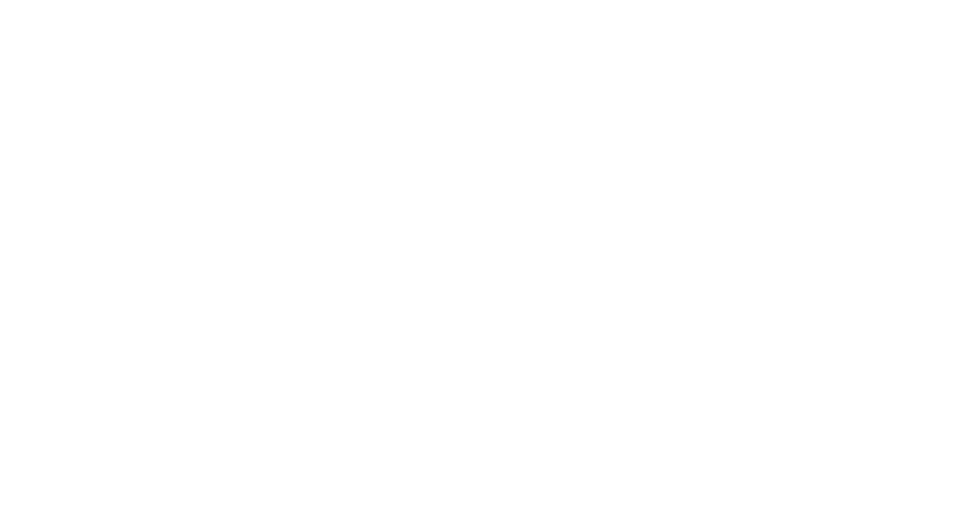

40      10.40
748     17.48
1218    22.18
1727    27.27
2231    32.31
2634    36.34
3047    40.47
3529    45.29
3857    48.57
4369    53.69
5124    61.24
5605    66.05
6279    72.79
6692    76.92
6720    77.20
6775    77.75
6960    79.60
Name: two_theta, dtype: float64


In [2]:
def find_peak_centers(x, y, widths=(40, 50)):
    peak_indices = signal.find_peaks_cwt(y, widths)
    return x[peak_indices]

peak_centers_approx = find_peak_centers(df['two_theta'], df['intensity'], widths=(40, 50))

# Clear the current figure to prevent overlapping legends
plt.clf()

# Plot data with peak positions
fig, ax = plt.subplots()
ax.scatter(df['two_theta'], df['intensity'], s=3)
ax.vlines(peak_centers_approx, ymin=0, ymax=np.max(df['intensity']), linestyles='dotted', color='k')
ax.set_ylim(0,25000)
#ax.set_xlim(70,75)
plt.show()

print(peak_centers_approx)

## Peak Base Function

This block of code:
1. Finds the lowest value points either side of each peak within a range 
2. Plot peaks function plots each minimum point on the intensity data as a red cross
3. Using numpy interpolate function to extrapolate data points
4. Plot and subtract the extrapolated data from the raw data 
5. Shows the resulting baseline corrected data

<IPython.core.display.Javascript object>


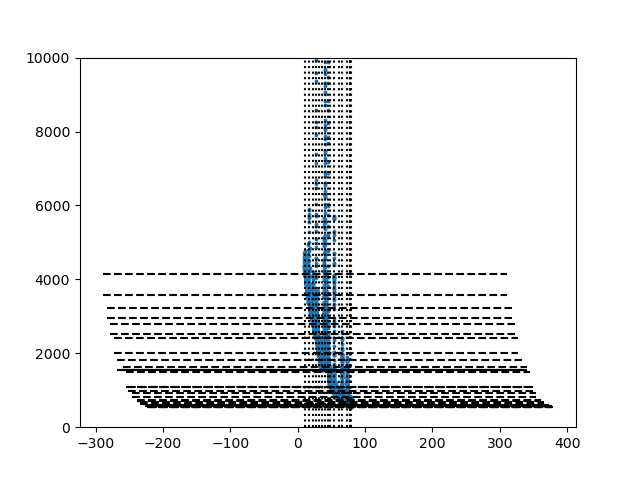

<IPython.core.display.Javascript object>


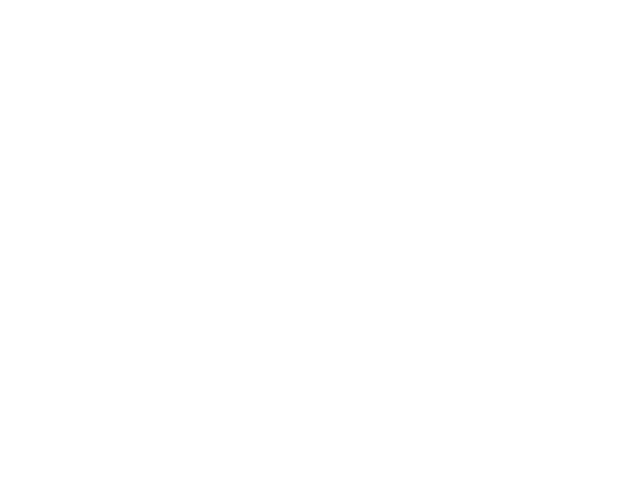

,two_theta,intensity,baseline,base_sub_intensity
0,10.00,4625.0,4135.000000,490.000000
1,10.01,4715.0,4133.352941,581.647059
2,10.02,4460.0,4131.705882,328.294118
3,10.03,4520.0,4130.058824,389.941176
4,10.04,4135.0,4128.411765,6.588235


In [3]:
# Function to identify the base  level either side of the peak center position 
def find_peak_bases(x, y, peak_centers, window=10):
    peak_bases = []
    for center in peak_centers:
        center_idx = np.argmin(np.abs(x - center))
        left_idx = max(center_idx - window, 0)
        right_idx = min(center_idx + window, len(x) - 1)
        left_base = np.min(y[left_idx:center_idx])
        right_base = np.min(y[center_idx:right_idx])
        peak_bases.append((left_base, right_base))
    return peak_bases

# Number of points around the peak position to find the minimum
window = 300
peak_bases = find_peak_bases(df['two_theta'], df['intensity'], peak_centers_approx, window=window)

# Clear the current figure to prevent overlapping legends
plt.clf()

fig, ax = plt.subplots()
ax.scatter(df['two_theta'], df['intensity'], s=3)
ax.vlines(peak_centers_approx, ymin=0, ymax=np.max(df['intensity']), linestyles='dotted', color='k')
ax.set_ylim(0,10000)
for center, (left_base, right_base) in zip(peak_centers_approx, peak_bases):
    ax.hlines([left_base, right_base], xmin=center-window, xmax=center+window, linestyles='dashed', color='k')
plt.show()

# Plot peaks function to plot the base level either side of the peaks as a red cross
def plot_peaks(x, y, peak_centers, peak_bases, ymax=np.max(df['intensity']), num_interp=len(df['two_theta'])):
    fig, ax = plt.subplots()
    ax.scatter(x, y, s=3)
    bases_unzip = []
    base_coords = np.empty((0,2))
    for center, bases in zip(peak_centers, peak_bases):
        center_idx = np.argmin(np.abs(x - center))
        left_base, right_base = bases
        left_idx = max(center_idx - window, 0)
        right_idx = min(center_idx + window, len(x) - 1)
        ax.plot([center], [y[center_idx]], 'ko')
        bases_unzip.extend([left_base, right_base])
        base_coords = np.vstack((base_coords, [[x[left_idx], left_base], [x[right_idx], right_base]]))
        
    # Plot the base coordinates
    for coord in base_coords:
        ax.plot(coord[0], coord[1], 'rx', markersize=10)
        
    # Interpolate base coordinates
    x_coords = base_coords[:, 0]
    y_coords = base_coords[:, 1]
    interp_fn = interp1d(x_coords, y_coords, kind='linear', bounds_error=False, fill_value="extrapolate")
    x_i = np.linspace(np.min(x_coords), np.max(x_coords), num_interp)
    y_i = interp_fn(x_i)
    df['baseline'] = y_i
    
    # Subtract the interpolated base values from the intensity data
    y_sub = y - interp_fn(x)
    df['base_sub_intensity'] = y_sub
    
    ax.plot(x_i, y_i, 'kx', markersize=1)    
    ax.plot(x, y_sub, 'r-', linewidth=0.5)
    ax.set_ylim(0, ymax)
    plt.xlabel("2θ (degrees)")
    plt.ylabel("Intensity (counts)")
    plt.title(file_title)
    plt.show()
    return base_coords, y_sub
    
plot_peaks(df['two_theta'], df['intensity'], peak_centers_approx, peak_bases, 10000)

df.head()

## Find True Peak Position

This code finds the true peak postition using scipy find_peaks function calling two parameters:
1. 'prominence': It specifies the minimum prominence of peaks. Higher values will result in only prominent peaks being detected, potentially reducing the detection of overlapping peaks.
2. 'distance': It specifies the minimum horizontal distance between neighboring peaks. Smaller values will allow for closer peaks to be identified as separate peaks.

[10.33 17.46 17.48 22.15 27.22 32.33 36.27 40.45 45.23 48.73 53.66 56.41
 61.08 66.02 72.69 76.82]


<IPython.core.display.Javascript object>


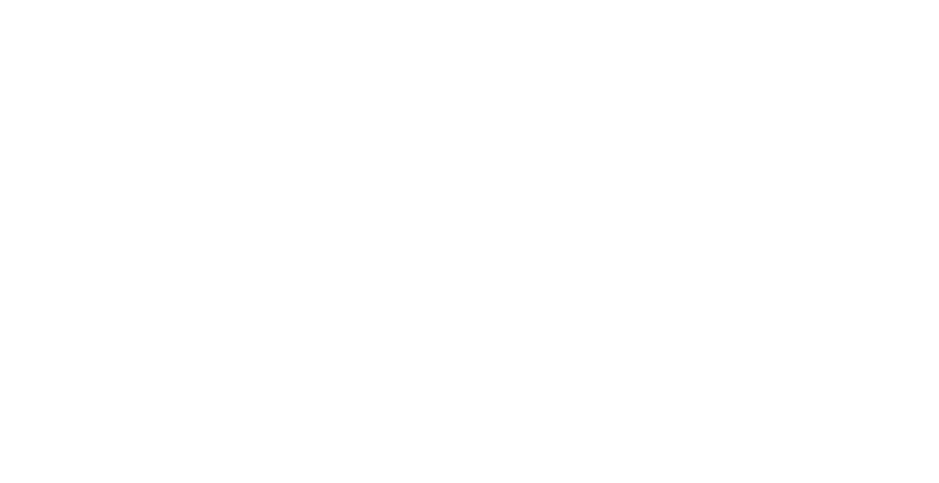

In [6]:
peak_centers = []
def find_peak_centers(x, y, peak_centers_approx, window_size=20, prominence=100, distance=100):
    peak_centers = []
    for center in peak_centers_approx:
        start_index = np.abs(x - center).argmin()
        start_index = max(start_index - window_size, 0)
        end_index = min(start_index + window_size*2, len(y))
        
        peaks, _ = find_peaks(y[start_index:end_index], prominence=prominence, distance=distance)
        peak_indices = peaks + start_index
        
        peak_centers.extend(x[peak_indices])
    
    return np.array(peak_centers)

# Line of code to append and remove any approximate peak positions
peak_centers_approx = np.append(peak_centers_approx, [56.3])

peak_centers = find_peak_centers(df['two_theta'], df['base_sub_intensity'], peak_centers_approx, window_size=20, prominence=100, distance=50)

### Append peak centers manually ###
peak_centers = np.append(peak_centers, [17.48])

# Filter peak_centers based on base_sub_intensity > 1000
mask = np.isin(df['two_theta'], peak_centers)
peak_centers = np.extract(mask & (df['base_sub_intensity'] > 300), df['two_theta'])

# Sort the peak_centers array in ascending order
peak_centers = np.sort(peak_centers)

# Remove duplicate values from the peak_centers array
peak_centers = np.unique(peak_centers)
print(peak_centers)

# Clear the current figure to prevent overlapping legends
plt.clf()

# Create a figure and axes for the plot
fig, ax = plt.subplots()
plt.subplots_adjust(bottom=0.25)

# Plot data with refined peak positions
scatter = ax.scatter(df['two_theta'], df['base_sub_intensity'], s=2)
vlines = ax.vlines(peak_centers, ymin=0, ymax=np.max(df['base_sub_intensity']), linestyles='dotted', color='k')


## Gaussian & Lorentian Functions

In [7]:
####### Gaussian #######

def _1gaussian(x_array, amp1, cen1, sigma1):
    return amp1 * (1 / (sigma1 * (np.sqrt(2 * np.pi)))) * (np.exp((-1.0 / 2.0) * (((x_array - cen1) / sigma1) ** 2)))

def _2gaussian(x_array, amp1,cen1,sigma1, amp2,cen2,sigma2):
    return amp1*(1/(sigma1*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x_array-cen1)/sigma1)**2))) + \
            amp2*(1/(sigma2*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x_array-cen2)/sigma2)**2)))

###### Lorentzian #########

def _1Lorentzian(x, amp1, cen1, wid1, amp2,cen2,wid2, amp3,cen3,wid3):
    return (amp1*wid1**2/((x-cen1)**2+wid1**2)) 

###### Voigt #######

def _1Voigt(x, ampG1, cenG1, sigmaG1, ampL1, cenL1, widL1):
    return (ampG1*(1/(sigmaG1*(np.sqrt(2*np.pi))))*(np.exp(-((x-cenG1)**2)/((2*sigmaG1)**2)))) +\
              ((ampL1*widL1**2/((x-cenL1)**2+widL1**2)) )


def _2Voigt(x, ampG1, cenG1, sigmaG1, ampL1, cenL1, widL1, ampG2, cenG2, sigmaG2, ampL2, cenL2, widL2):
    return (ampG1*(1/(sigmaG1*(np.sqrt(2*np.pi))))*(np.exp(-((x-cenG1)**2)/((2*sigmaG1)**2)))) +\
              ((ampL1*widL1**2/((x-cenL1)**2+widL1**2)) ) +\
            (ampG2*(1/(sigmaG2*(np.sqrt(2*np.pi))))*(np.exp(-((x-cenG2)**2)/((2*sigmaG2)**2)))) +\
              ((ampL2*widL2**2/((x-cenL2)**2+widL2**2)) )

## Voigt Dataframe

In [8]:
# Create a pandas DataFrame to store the Gaussian fit results
fit_results_df = pd.DataFrame(columns=['Peak Index', 'Gaussian Amplitude', 'Gaussian Center', 'Gaussian Standard Deviation', 'Lorentzian Amplitude', 'Lorentzian Center', 'Lorentzian Width', 'R Squared', 'Chi Squared', 'Voigt Width'])

## Individual Voigt Fitting

<IPython.core.display.Javascript object>


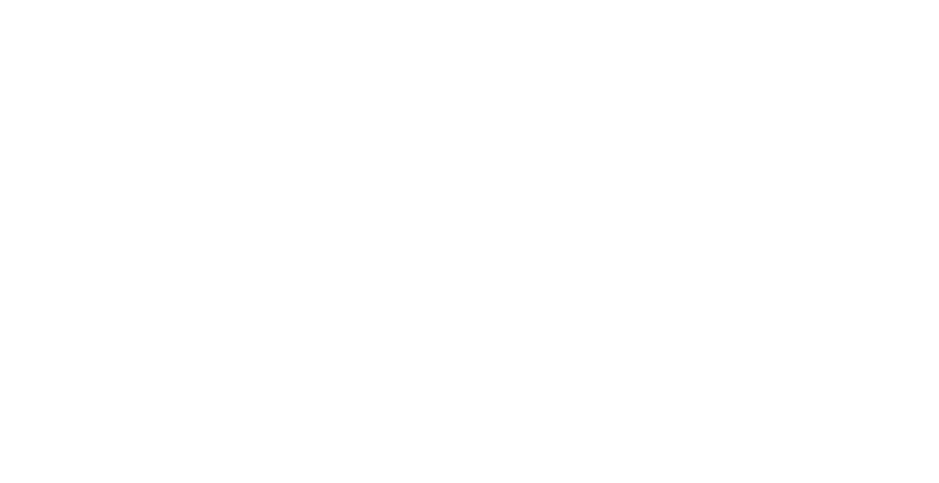

In [9]:
# Select the peak index to fit
peak_index = 10 # Adjust this index according to the peak you want to fit

# Define the data range for fitting
fit_range = (53.6,53.76)
# Find the indices corresponding to the fit range
fit_indices = np.where((df['two_theta'] >= fit_range[0]) & (df['two_theta'] <= fit_range[1]))[0]

# Extract the data within the fit range
x_fit = df['two_theta'][fit_indices]
y_fit = df['base_sub_intensity'][fit_indices]

# Select the peak position for fitting
x_peak = peak_centers[peak_index]

# Define an appropriate x range around the peak
x_range = np.linspace(x_peak - 1, x_peak + 1, 1000)

# Fit the Gaussian function to the selected peak
p0 = [np.argmax(np.abs(x_fit - x_peak)), x_peak, np.std(x_fit), np.argmax(np.abs(x_fit - x_peak)), x_peak, np.std(x_fit)]  # Initial guess for the Gaussian parameters
popt, pcov = curve_fit(_1Voigt, x_fit, y_fit, p0=p0)

# Generate the fitted curve using the optimized parameters
y_curve_fit = _1Voigt(x_range, *popt)

# Calculate the residuals
residuals = y_fit - _1Voigt(x_fit, *popt)
ssr = np.sum(residuals**2)  # Sum of squared residuals

# Calculate total sum of squares
y_mean = np.mean(y_fit)
sst = np.sum((y_fit - y_mean)**2)

# Calculate R-squared
r_squared = 1 - (ssr / sst)

# Calculate degrees of freedom
n_data = len(y_fit)
n_params = len(popt)
dof = n_data - n_params

# Calculate chi-squared
chi_squared = np.sum((residuals / y_fit)**2)

# Calculate the Voigt peak width
sigmaG = popt[2]  # Gaussian standard deviation
widL = popt[5]  # Lorentzian width
voigt_width = 2 * sigmaG * np.sqrt(2 * np.log(2)) + 2 * widL * scipy.special.wofz(1j)

# Clear the current figure to prevent overlapping legends
plt.clf()

# Plot the data and the fitted curve
plt.scatter(df['two_theta'], df['base_sub_intensity'], s=2, c='k', label='Raw Data')
plt.plot(x_range, y_curve_fit, color='r', label='Voigt Fit')
plt.vlines(x_peak, ymin=0, ymax=np.max(df['base_sub_intensity']), linestyles='dotted', color='k', label='Selected Peak')

#plt.ylim(0, np.max(y_fit)+10000)
#plt.xlim(peak_centers[peak_index] - 0.5, peak_centers[peak_index] + 0.5)
plt.legend()

# Display the plot interactively
display(plt.gcf())

## Add Fit results to dataframe

In [10]:
# Append the fit results to the DataFrame
fit_results_df = fit_results_df.append({'Peak Index': peak_index, 'Gaussian Amplitude': popt[0], 'Gaussian Center': popt[1], 'Gaussian Standard Deviation': popt[2], 'Lorentzian Amplitude': popt[3], 'Lorentzian Center':popt[4], 'Lorentzian Width':popt[5], 'R Squared':r_squared, 'Chi Squared':chi_squared, 'Voigt Width':voigt_width}, ignore_index=True)

# Remove rows with duplicate peak index
fit_results_df = fit_results_df.drop_duplicates(subset='Peak Index', keep='last')

# Remove parentheses from values in the fit_results_df dataframe
fit_results_df['Peak Index'] = fit_results_df['Peak Index'].apply(lambda x: re.sub(r'\(|\)', '', str(x)))
fit_results_df['Gaussian Amplitude'] = fit_results_df['Gaussian Amplitude'].apply(lambda x: re.sub(r'\(|\)', '', str(x)))
fit_results_df['Gaussian Center'] = fit_results_df['Gaussian Center'].apply(lambda x: re.sub(r'\(|\)', '', str(x)))
fit_results_df['Gaussian Standard Deviation'] = fit_results_df['Gaussian Standard Deviation'].apply(lambda x: re.sub(r'\(|\)', '', str(x)))
fit_results_df['Lorentzian Amplitude'] = fit_results_df['Lorentzian Amplitude'].apply(lambda x: re.sub(r'\(|\)', '', str(x)))
fit_results_df['Lorentzian Center'] = fit_results_df['Lorentzian Center'].apply(lambda x: re.sub(r'\(|\)', '', str(x)))
fit_results_df['Lorentzian Width'] = fit_results_df['Lorentzian Width'].apply(lambda x: re.sub(r'\(|\)', '', str(x)))
fit_results_df['R Squared'] = fit_results_df['R Squared'].apply(lambda x: re.sub(r'\(|\)', '', str(x)))
fit_results_df['Chi Squared'] = fit_results_df['Chi Squared'].apply(lambda x: re.sub(r'\(|\)', '', str(x)))
fit_results_df['Voigt Width'] = fit_results_df['Voigt Width'].apply(lambda x: re.sub(r'\(|\)', '', str(x)))

# Remove imaginary part from values in the fit_results_df dataframe
fit_results_df['Peak Index'] = fit_results_df['Peak Index'].apply(lambda x: complex(x.replace('(', '').replace(')', '')).real)
fit_results_df['Gaussian Amplitude'] = fit_results_df['Gaussian Amplitude'].apply(lambda x: complex(x.replace('(', '').replace(')', '')).real)
fit_results_df['Gaussian Center'] = fit_results_df['Gaussian Center'].apply(lambda x: complex(x.replace('(', '').replace(')', '')).real)
fit_results_df['Gaussian Standard Deviation'] = fit_results_df['Gaussian Standard Deviation'].apply(lambda x: complex(x.replace('(', '').replace(')', '')).real)
fit_results_df['Lorentzian Amplitude'] = fit_results_df['Lorentzian Amplitude'].apply(lambda x: complex(x.replace('(', '').replace(')', '')).real)
fit_results_df['Lorentzian Center'] = fit_results_df['Lorentzian Center'].apply(lambda x: complex(x.replace('(', '').replace(')', '')).real)
fit_results_df['Lorentzian Width'] = fit_results_df['Lorentzian Width'].apply(lambda x: complex(x.replace('(', '').replace(')', '')).real)
fit_results_df['R Squared'] = fit_results_df['R Squared'].apply(lambda x: complex(x.replace('(', '').replace(')', '')).real)
fit_results_df['Chi Squared'] = fit_results_df['Chi Squared'].apply(lambda x: complex(x.replace('(', '').replace(')', '')).real)
fit_results_df['Voigt Width'] = fit_results_df['Voigt Width'].apply(lambda x: complex(x.replace('(', '').replace(')', '')).real)

# Display the fit results
display(fit_results_df)

,Peak Index,Gaussian Amplitude,Gaussian Center,Gaussian Standard Deviation,Lorentzian Amplitude,Lorentzian Center,Lorentzian Width,R Squared,Chi Squared,Voigt Width
0,10.0,13.628692,53.74804,0.008849,4857.941682,53.669398,-0.094375,0.971445,0.011003,-0.059868


## Save/Load Fit Results from a txt file

In [44]:
# Figure save settings
save_dir = os.path.join(folder_path, 'XRD Plots')
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
fit_results_df.to_csv(os.path.join(save_dir, file_title + ' fit parameters' + '.txt'), index=False, sep='\t')

In [11]:
############ SKIP THIS CELL IF YOU WILL NOW DO FITTING ###########
subfolder_plots = 'XRD Plots'
folder_path_load = 'C:\\Users\\w16025698\\OneDrive - Northumbria University - Production Azure AD\\PhD\\Characterisation\\XRD\\230607_XRD'
folder_path_plots = os.path.join(folder_path_load, subfolder_plots)

fit_results_filename = '230221G_XRD fit parameters.txt'
fit_results_df = pd.read_csv(os.path.join(folder_path_plots, fit_results_filename), sep='\t', skiprows=1, header=None, names=['Peak Index', 'Gaussian Amplitude', 'Gaussian Center', 'Gaussian Standard Deviation', 'Lorentzian Amplitude', 'Lorentzian Center', 'Lorentzian Width', 'R Squared', 'Chi Squared', 'Voigt Width'])

# Order the values
fit_results_df = fit_results_df.sort_values('Peak Index')

# Remove parentheses from values in the fit_results_df dataframe
fit_results_df['Peak Index'] = fit_results_df['Peak Index'].apply(lambda x: re.sub(r'\(|\)', '', str(x)))
fit_results_df['Gaussian Amplitude'] = fit_results_df['Gaussian Amplitude'].apply(lambda x: re.sub(r'\(|\)', '', str(x)))
fit_results_df['Gaussian Center'] = fit_results_df['Gaussian Center'].apply(lambda x: re.sub(r'\(|\)', '', str(x)))
fit_results_df['Gaussian Standard Deviation'] = fit_results_df['Gaussian Standard Deviation'].apply(lambda x: re.sub(r'\(|\)', '', str(x)))
fit_results_df['Lorentzian Amplitude'] = fit_results_df['Lorentzian Amplitude'].apply(lambda x: re.sub(r'\(|\)', '', str(x)))
fit_results_df['Lorentzian Center'] = fit_results_df['Lorentzian Center'].apply(lambda x: re.sub(r'\(|\)', '', str(x)))
fit_results_df['Lorentzian Width'] = fit_results_df['Lorentzian Width'].apply(lambda x: re.sub(r'\(|\)', '', str(x)))
fit_results_df['R Squared'] = fit_results_df['R Squared'].apply(lambda x: re.sub(r'\(|\)', '', str(x)))
fit_results_df['Chi Squared'] = fit_results_df['Chi Squared'].apply(lambda x: re.sub(r'\(|\)', '', str(x)))
fit_results_df['Voigt Width'] = fit_results_df['Voigt Width'].apply(lambda x: re.sub(r'\(|\)', '', str(x)))

# Remove imaginary part from values in the fit_results_df dataframe
fit_results_df['Peak Index'] = fit_results_df['Peak Index'].apply(lambda x: complex(x.replace('(', '').replace(')', '')).real)
fit_results_df['Gaussian Amplitude'] = fit_results_df['Gaussian Amplitude'].apply(lambda x: complex(x.replace('(', '').replace(')', '')).real)
fit_results_df['Gaussian Center'] = fit_results_df['Gaussian Center'].apply(lambda x: complex(x.replace('(', '').replace(')', '')).real)
fit_results_df['Gaussian Standard Deviation'] = fit_results_df['Gaussian Standard Deviation'].apply(lambda x: complex(x.replace('(', '').replace(')', '')).real)
fit_results_df['Lorentzian Amplitude'] = fit_results_df['Lorentzian Amplitude'].apply(lambda x: complex(x.replace('(', '').replace(')', '')).real)
fit_results_df['Lorentzian Center'] = fit_results_df['Lorentzian Center'].apply(lambda x: complex(x.replace('(', '').replace(')', '')).real)
fit_results_df['Lorentzian Width'] = fit_results_df['Lorentzian Width'].apply(lambda x: complex(x.replace('(', '').replace(')', '')).real)
fit_results_df['R Squared'] = fit_results_df['R Squared'].apply(lambda x: complex(x.replace('(', '').replace(')', '')).real)
fit_results_df['Chi Squared'] = fit_results_df['Chi Squared'].apply(lambda x: complex(x.replace('(', '').replace(')', '')).real)
fit_results_df['Voigt Width'] = fit_results_df['Voigt Width'].apply(lambda x: complex(x.replace('(', '').replace(')', '')).real)

# Display the fit results
display(fit_results_df)

,Peak Index,Gaussian Amplitude,Gaussian Center,Gaussian Standard Deviation,Lorentzian Amplitude,Lorentzian Center,Lorentzian Width,R Squared,Chi Squared,Voigt Width
0,4.0,3695.220260,27.195038,0.016038,22715.909950,27.196354,0.106149,0.999206,188.176761,0.128542
1,7.0,11105.032121,285.318662,1.571670,21756.236448,40.470437,-0.180210,0.997211,34.753216,3.546890
2,8.0,91.023425,45.182575,0.013508,10667.429042,45.208970,0.090655,0.998609,0.001284,0.109334
3,10.0,542.760776,53.619130,0.058293,887.051946,53.625841,0.021878,0.973004,0.009012,0.155979


## Sum of Fitting Plot

<IPython.core.display.Javascript object>


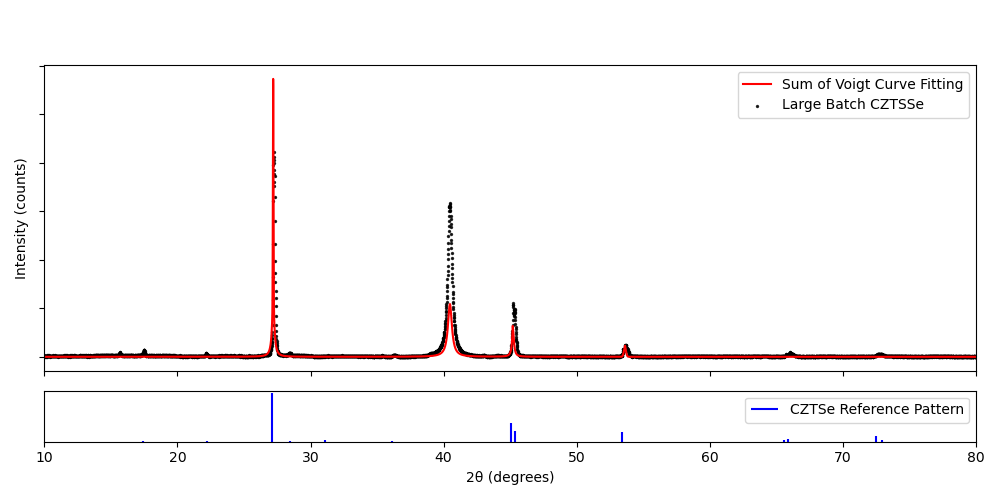

In [12]:
# Load the XRD reference pattern from Excel
#display(reference_df)

# Define the x range for plotting
x_range = np.linspace(df['two_theta'].min(), df['two_theta'].max(), 100000)

# Initialize the sum of curves
sum_curves = np.zeros_like(x_range)

# Iterate over each row in the DataFrame
for index, row in fit_results_df.iterrows():
    G_amplitude = row['Gaussian Amplitude']
    G_center = row['Gaussian Center']
    G_sigma = row['Gaussian Standard Deviation']
    L_amplitude = row['Lorentzian Amplitude']
    L_center = row['Lorentzian Center']
    L_width = row['Lorentzian Width']
    
    # Generate the Voigt curve for the current row
    curve = _1Voigt(x_range, G_amplitude, G_center, G_sigma, L_amplitude, L_center, L_width)
    
    # Add the current curve to the sum of curves
    sum_curves += curve

# Clear the current figure to prevent overlapping legends
plt.clf()

# Create subplots with shared x-axis
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 5), gridspec_kw={'height_ratios': [6, 1]})

# Plot the sum of curves on the first subplot
ax1.plot(x_range, sum_curves, color='r', label='Sum of Voigt Curve Fitting')
ax1.scatter(df['two_theta'], df['base_sub_intensity'], s=2, c='k', alpha=0.8, label='Large Batch CZTSSe ')
ax1.set_ylabel("Intensity (counts)")
ax1.set_yticklabels([])  # Remove y-axis tick labels
ax1.set_xlim(10,80)
ax1.legend()

# Plot the XRD reference pattern on the second subplot
ax2.vlines(CZTSe_reference_df['Two Theta'], 0, CZTSe_reference_df['Intensity'], colors='b', label='CZTSe Reference Pattern')
ax2.set_xlabel("2θ (degrees)")
ax2.set_yticks([])
ax2.set_ylim(0,105)
#ax2.set_ylabel("Intensity (counts)")
ax2.legend()

# Adjust spacing between subplots and set the height of the reference subplot
plt.subplots_adjust(hspace=0.1)
plt.tight_layout(rect=[0, 0, 1, 0.9])
figure_title = 'Small Batch XRD plot'

plt.show()

save_dir = os.path.join(folder_path, 'XRD Plots')
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Save the plot as an image file
plt.savefig(os.path.join(save_dir, figure_title + '.png'), dpi=500)


## Save entire Dataframe to Excel file

In [46]:
excel_file_title = '230310E_XRD.xlsx'

excel_file_path = os.path.join(folder_path, excel_file_title)

# Check if the Excel file already exists
if os.path.isfile(excel_file_path):
    # If the file exists, delete it
    os.remove(excel_file_path)

# Create a Pandas Excel writer
writer = pd.ExcelWriter(excel_file_path, engine='xlsxwriter')

# Write the DataFrames to separate sheets in the Excel file
fit_results_df.to_excel(writer, sheet_name='Fit Results', index=False)
df.to_excel(writer, sheet_name='Raw Data', index=False)

# Save the Excel file
writer.save()

# Close the Excel file
writer.close()

C:\Users\w16025698\Anaconda3\lib\site-packages\xlsxwriter\workbook.py:338: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")


## Stacked Plot

<IPython.core.display.Javascript object>


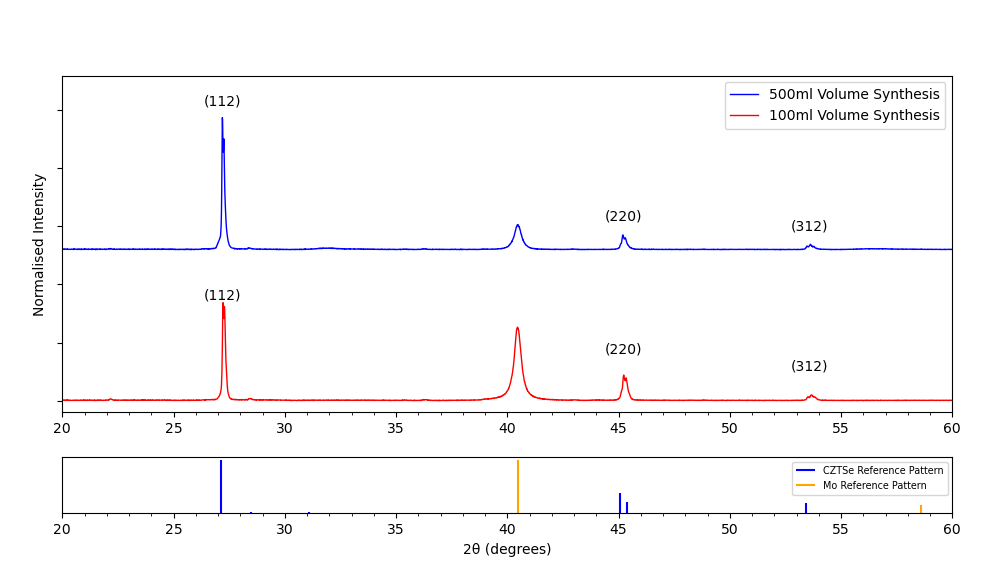

In [65]:
# Load additional Excel file for stacked plot
additional_data = pd.read_excel("C:\\Users\\w16025698\\OneDrive - Northumbria University - Production Azure AD\\PhD\\Characterisation\\XRD\\230607_XRD\\230221G_XRD.xlsx", sheet_name= 'Raw Data')

# Clear the current figure to prevent overlapping legends
plt.clf()

# Create subplots with shared x-axis
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(7, 5), gridspec_kw={'height_ratios': [6, 1]})

# x axis limits
xmin = 20
xmax = 60

peaks = {27.2:'(112)', 45.2:'(220)', 53.6:'(312)'}

for x, number in peaks.items():
    closest_index = (df['two_theta'] - x).abs().idxmin()
    closest_value = df['two_theta'][closest_index]
    peak_offset = df['base_sub_intensity'][closest_index] 
    ax1.text(closest_value, peak_offset+20000, str(number), ha='center', va='bottom')
    
for x, number in peaks.items():
    closest_index = (additional_data['two_theta'] - x).abs().idxmin()
    closest_value = additional_data['two_theta'][closest_index]
    peak_offset = additional_data['base_sub_intensity'][closest_index] 
    ax1.text(closest_value, peak_offset+140000, str(number), ha='center', va='bottom')

# Plot the data from the 'Raw Data' sheet on the first subplot
ax1.plot(additional_data['two_theta'], additional_data['base_sub_intensity']+130000, c='b', lw=1, label='500ml Volume Synthesis')
ax1.plot(df['two_theta'], df['base_sub_intensity'], c='r',lw=1, label='100ml Volume Synthesis')
ax1.set_yticklabels([])
ax1.set_ylabel('Normalised Intensity')
ax1.set_xlim(xmin, xmax)
ax1.set_ylim(-10000, 280000)
ax1.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax1.xaxis.set_tick_params(which='both', labelbottom=True)
ax1.legend()

# Plot the XRD reference pattern on the second subplot
ax2.vlines(CZTSe_reference_df['Two Theta'], 0, CZTSe_reference_df['Intensity'], colors='b', label='CZTSe Reference Pattern')
#ax2.vlines(MoSe2_reference_df['Two Theta'], 0, MoSe2_reference_df['Intensity'], colors='orange', label='MoSe2 Reference Pattern')
ax2.vlines(Mo_reference_df['Two Theta'], 0, Mo_reference_df['Intensity'], colors='orange', label='Mo Reference Pattern')
ax2.set_xlabel("2θ (degrees)")
ax2.set_yticks([])
ax2.set_ylim(0,105)
#ax2.set_ylabel("Intensity (counts)")
ax2.legend(fontsize='x-small')
ax2.set_xlim(xmin, xmax)

# Adjust spacing between subplots and set the height of the reference subplot
plt.subplots_adjust(hspace=0.1)
plt.tight_layout(rect=[0, 0, 1, 0.9])
figure_title = 'Small Large Comparison XRD plot 08.06.23'

plt.show()

save_dir = os.path.join(folder_path, 'XRD Plots')
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Save the plot as an image file
plt.savefig(os.path.join(save_dir, figure_title + ' stacked.png'), dpi=500)


## Peak Ratio Calculation